In [48]:
import sys 
sys.path.append('../src/')
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
from scipy import stats
import config
import helper
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

warnings.filterwarnings('ignore')

%matplotlib inline


In [49]:
df = pd.read_csv('../data/raw_data/clevelanda.csv', na_values='?')
df.head()

,age,gender,cp,trestbps,chol,fps,restecg,thalach,exang,oldpeak,slope,ca,thal,class
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [50]:
# clean data
# first remove missing values
df.isnull().sum()


age         0
gender      0
cp          0
trestbps    0
chol        0
fps         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
class       0
dtype: int64

In [51]:
# Impute missing values with mode for 'ca' and 'thal'
df['ca'].fillna(df['ca'].mode()[0], inplace=True)
df['thal'].fillna(df['thal'].mode()[0], inplace=True)

# Print missing values count after imputation
print("Missing values after imputation:")
print(df.isnull().sum())

Missing values after imputation:
age         0
gender      0
cp          0
trestbps    0
chol        0
fps         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
class       0
dtype: int64


In [52]:
# check duplicates
df.duplicated().any()

False

In [53]:
df

,age,gender,cp,trestbps,chol,fps,restecg,thalach,exang,oldpeak,slope,ca,thal,class
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0,1
299,68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,2
300,57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
301,57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1


In [54]:
features = ['age',
#  'gender',
 'cp',
 'trestbps',
 'chol',
#  'fps',
 'restecg',
 'thalach',
#  'exang',
 'oldpeak',
#  'slope',
 'ca',
 'thal',
#  'class'
 ]

In [55]:
def remove_outliers_modified_zscore(df, threshold=3.5):
    # Copy the DataFrame to avoid modifying the original data
    df_cleaned = df.copy()
    
    # Exclude the 'class' column from the outlier detection
    features = df_cleaned.columns[df_cleaned.columns != 'class']
    
    # Calculate the median and median absolute deviation (MAD)
    median = df_cleaned[features].median()
    mad = (df_cleaned[features] - median).abs().median()
    
    # Calculate the modified Z-scores
    modified_z_scores = 0.6745 * (df_cleaned[features] - median) / mad
    
    # Identify outliers
    outliers = (modified_z_scores.abs() > threshold).any(axis=1)
    
    # Remove outliers from the DataFrame
    df_cleaned = df_cleaned[~outliers]
    
    return outliers, df_cleaned

# Assuming df is your original DataFrame
outliers, df_clean = remove_outliers_modified_zscore(df[features])

# Drop rows with NaN values if there are any remaining
df_clean = df_clean.dropna().reset_index(drop=True)

print(df_clean)


     age  cp  trestbps  chol  restecg  thalach  oldpeak   ca  thal
0     37   3       130   250        0      187      3.5  0.0   3.0
1     41   2       130   204        2      172      1.4  0.0   3.0
2     56   2       120   236        0      178      0.8  0.0   3.0
3     57   4       120   354        0      163      0.6  0.0   3.0
4     56   2       140   294        2      153      1.3  0.0   3.0
..   ...  ..       ...   ...      ...      ...      ...  ...   ...
113   56   2       120   240        0      169      0.0  0.0   3.0
114   55   2       132   342        0      166      1.2  0.0   3.0
115   63   4       124   197        0      136      0.0  0.0   3.0
116   41   2       120   157        0      182      0.0  0.0   3.0
117   38   3       138   175        0      173      0.0  0.0   3.0

[118 rows x 9 columns]


ValueError: num must be an integer with 1 <= num <= 14, not 15

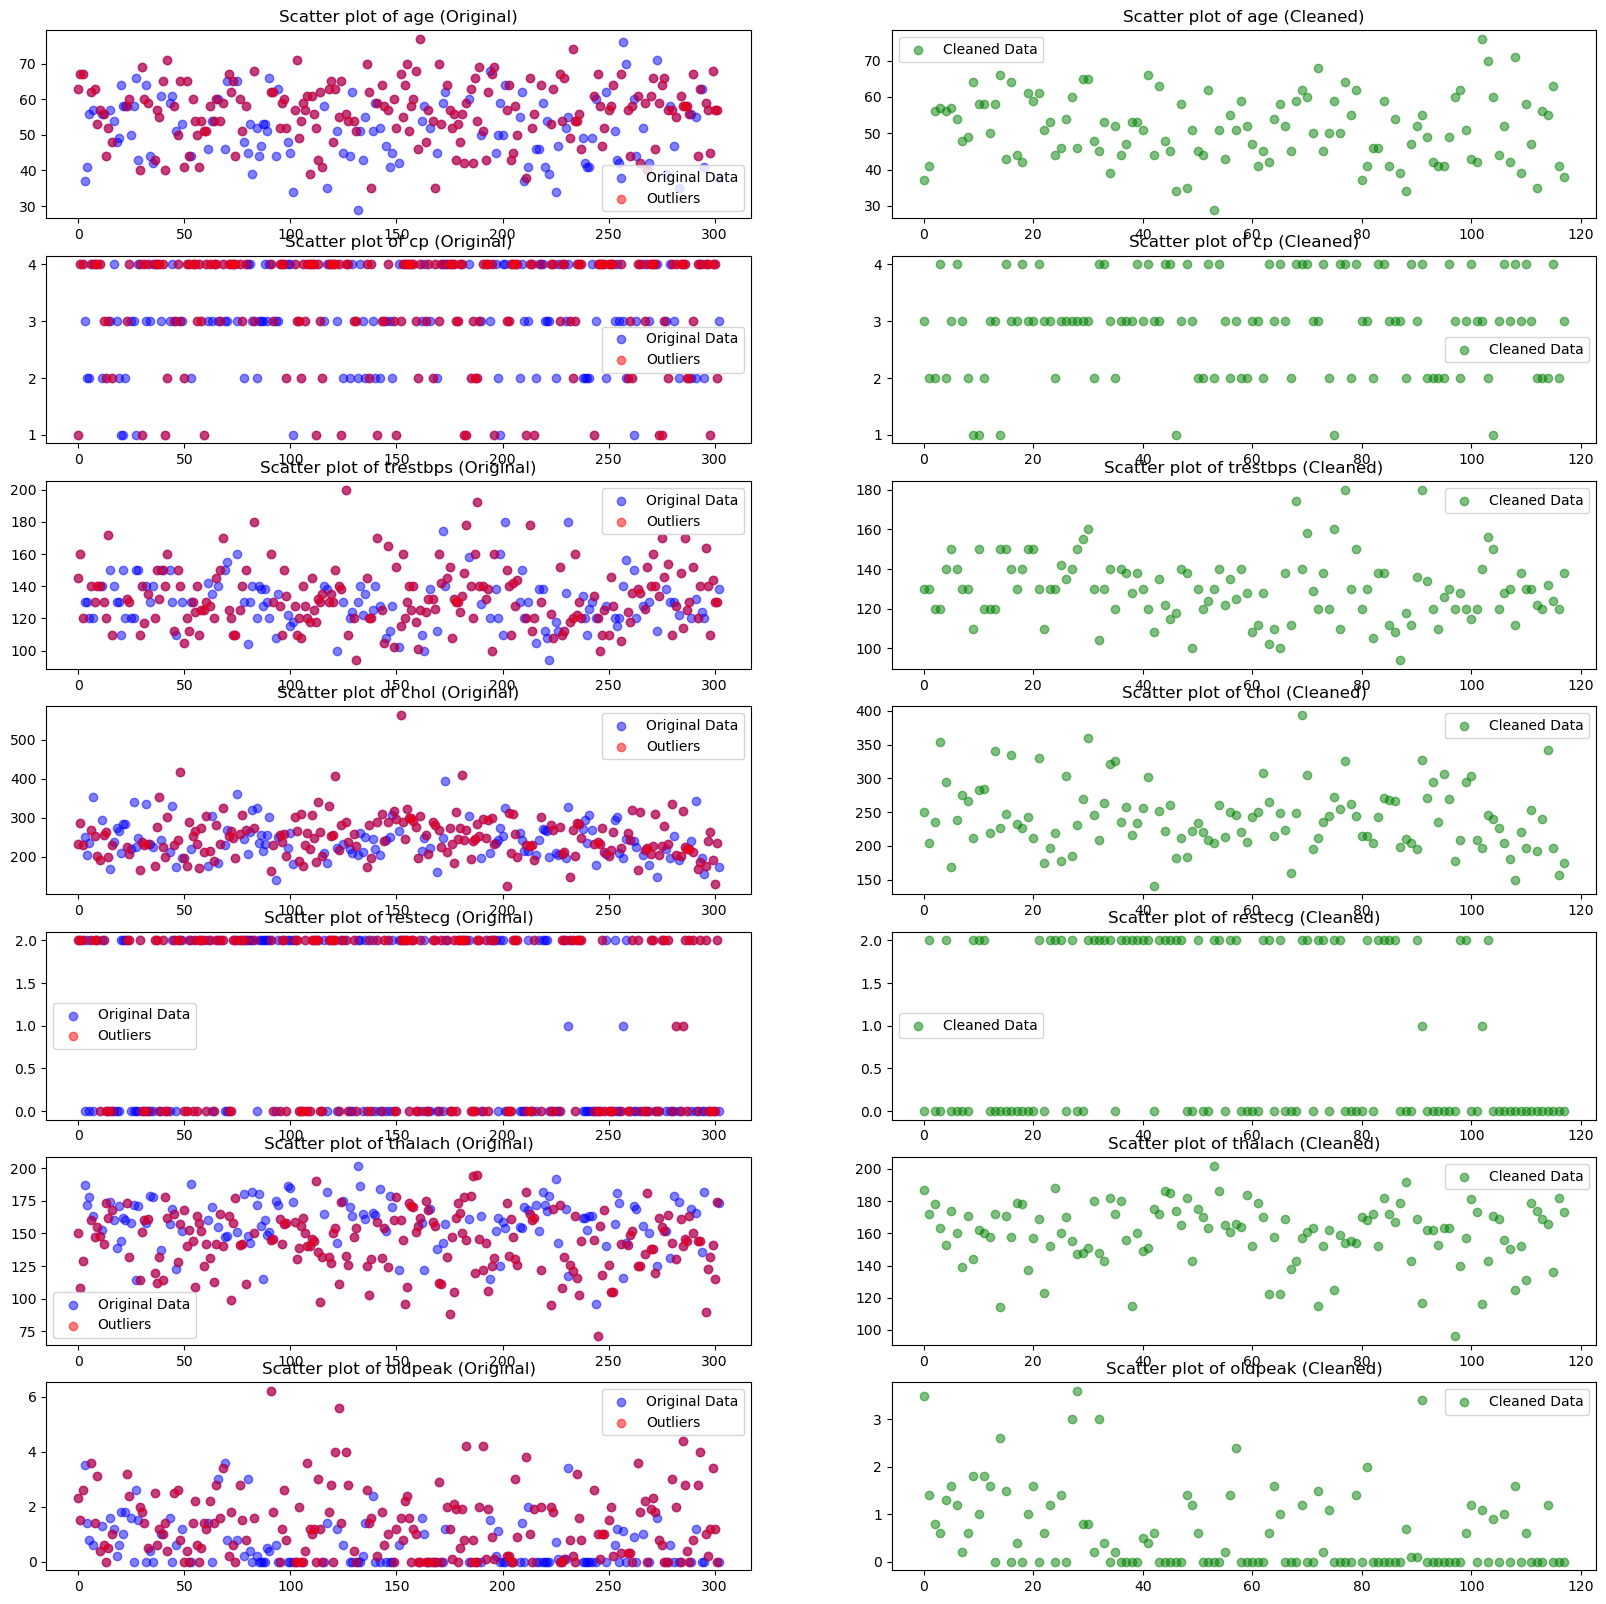

In [56]:
def outliers_plot(df, outliers, cleaned_df,  features):
  plt.figure(figsize=(20, 20))
  for i, feature in enumerate(features):
      # Orginal dataset with outliers
      plt.subplot(7, 2, 2 * i + 1)
      plt.scatter(df.index, df[feature], label='Original Data', color='blue', alpha=0.5)
      plt.scatter(df[outliers].index, df[outliers][feature], label='Outliers', color='red', alpha=0.5)
      plt.title(f'Scatter plot of {feature} (Original)')
      plt.legend()
      
      # Cleaned data wihtout outliers
      plt.subplot(7, 2, 2 * i + 2)
      plt.scatter(cleaned_df.index, cleaned_df[feature], label='Cleaned Data', color='green', alpha=0.5)
      plt.title(f'Scatter plot of {feature} (Cleaned)')
      plt.legend()

  plt.tight_layout()
  plt.show()

outliers_plot(df,outliers, df_clean,features)

In [61]:
remaining_cols = [
#   'age',
 'gender',
#  'cp',
#  'trestbps',
#  'chol',
 'fps',
#  'restecg',
#  'thalach',
 'exang',
#  'oldpeak',
 'slope',
#  'ca',
#  'thal',
 'class'
 ]


In [62]:
df_remaining = df[remaining_cols]

In [63]:
# Reset index of df_clean and df_remaining for merging
df_clean = df_clean.reset_index(drop=True)
df_remaining = df_remaining.reset_index(drop=True)

# Merge the dataframes based on the index
df_final = pd.concat([df_clean, df_remaining], axis=1)

df_final

,age,cp,trestbps,chol,restecg,thalach,oldpeak,ca,thal,gender,fps,exang,slope,class
0,37.0,3.0,130.0,250.0,0.0,187.0,3.5,0.0,3.0,1,1,0,3,0
1,41.0,2.0,130.0,204.0,2.0,172.0,1.4,0.0,3.0,1,0,1,2,2
2,56.0,2.0,120.0,236.0,0.0,178.0,0.8,0.0,3.0,1,0,1,2,1
3,57.0,4.0,120.0,354.0,0.0,163.0,0.6,0.0,3.0,1,0,0,3,0
4,56.0,2.0,140.0,294.0,2.0,153.0,1.3,0.0,3.0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,2,1
299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0,2,2
300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,2,3
301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,2,1


In [64]:
df_final

,age,cp,trestbps,chol,restecg,thalach,oldpeak,ca,thal,gender,fps,exang,slope,class
0,37.0,3.0,130.0,250.0,0.0,187.0,3.5,0.0,3.0,1,1,0,3,0
1,41.0,2.0,130.0,204.0,2.0,172.0,1.4,0.0,3.0,1,0,1,2,2
2,56.0,2.0,120.0,236.0,0.0,178.0,0.8,0.0,3.0,1,0,1,2,1
3,57.0,4.0,120.0,354.0,0.0,163.0,0.6,0.0,3.0,1,0,0,3,0
4,56.0,2.0,140.0,294.0,2.0,153.0,1.3,0.0,3.0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,2,1
299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0,2,2
300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,2,3
301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,2,1


In [65]:
df_final['class'].value_counts()

class
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64

In [66]:
df_final

,age,cp,trestbps,chol,restecg,thalach,oldpeak,ca,thal,gender,fps,exang,slope,class
0,37.0,3.0,130.0,250.0,0.0,187.0,3.5,0.0,3.0,1,1,0,3,0
1,41.0,2.0,130.0,204.0,2.0,172.0,1.4,0.0,3.0,1,0,1,2,2
2,56.0,2.0,120.0,236.0,0.0,178.0,0.8,0.0,3.0,1,0,1,2,1
3,57.0,4.0,120.0,354.0,0.0,163.0,0.6,0.0,3.0,1,0,0,3,0
4,56.0,2.0,140.0,294.0,2.0,153.0,1.3,0.0,3.0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,2,1
299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0,2,2
300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,2,3
301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,2,1


In [73]:
# Scale numerical features
from sklearn.preprocessing import StandardScaler, PowerTransformer
df_final = df_final.dropna().reset_index(drop=True)
X = df_final.drop('class', axis=1)
y = df_final['class']

scaler = PowerTransformer()
X_scaled = scaler.fit_transform(X)


In [74]:
# Apply SMOTE
smote = SMOTE(random_state=42, k_neighbors=3)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Combine into a new DataFrame
df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['class'])], axis=1)

print(df_resampled)

           age        cp    trestbps        chol  restecg     thalach  \
0    37.000000  3.000000  130.000000  250.000000      0.0  187.000000   
1    41.000000  2.000000  130.000000  204.000000      2.0  172.000000   
2    56.000000  2.000000  120.000000  236.000000      0.0  178.000000   
3    57.000000  4.000000  120.000000  354.000000      0.0  163.000000   
4    56.000000  2.000000  140.000000  294.000000      2.0  153.000000   
..         ...       ...         ...         ...      ...         ...   
325  50.681740  2.477267  134.772672  215.181863      2.0  177.022855   
326  53.992787  3.000000  134.275410  236.760654      2.0  155.840656   
327  44.025419  2.050838  129.618713  220.042184      2.0  187.923743   
328  50.352651  3.107891  128.381629  256.431566      2.0  152.884091   
329  57.591421  3.031429  139.214270  212.540030      2.0  165.628584   

      oldpeak   ca  thal  gender  fps  exang  slope  class  
0    3.500000  0.0   3.0       1    1      0      3      0  
1

In [75]:
df_resampled.to_csv("../data/clean_data/df_smote.csv", index=False)

In [76]:
df_resampled['class'].value_counts()

class
0    66
2    66
1    66
3    66
4    66
Name: count, dtype: int64

In [71]:
smote_df = pd.read_csv("../data/clean_data/train_smote_fold.csv")
smote_data  = smote_df.groupby('skfold')['class'].agg({'value_counts'}).reset_index()   
smote_data

,skfold,class,value_counts
0,0,0,14
1,0,1,13
2,0,2,13
3,0,3,13
4,0,4,13
5,1,2,14
6,1,0,13
7,1,1,13
8,1,3,13
9,1,4,13


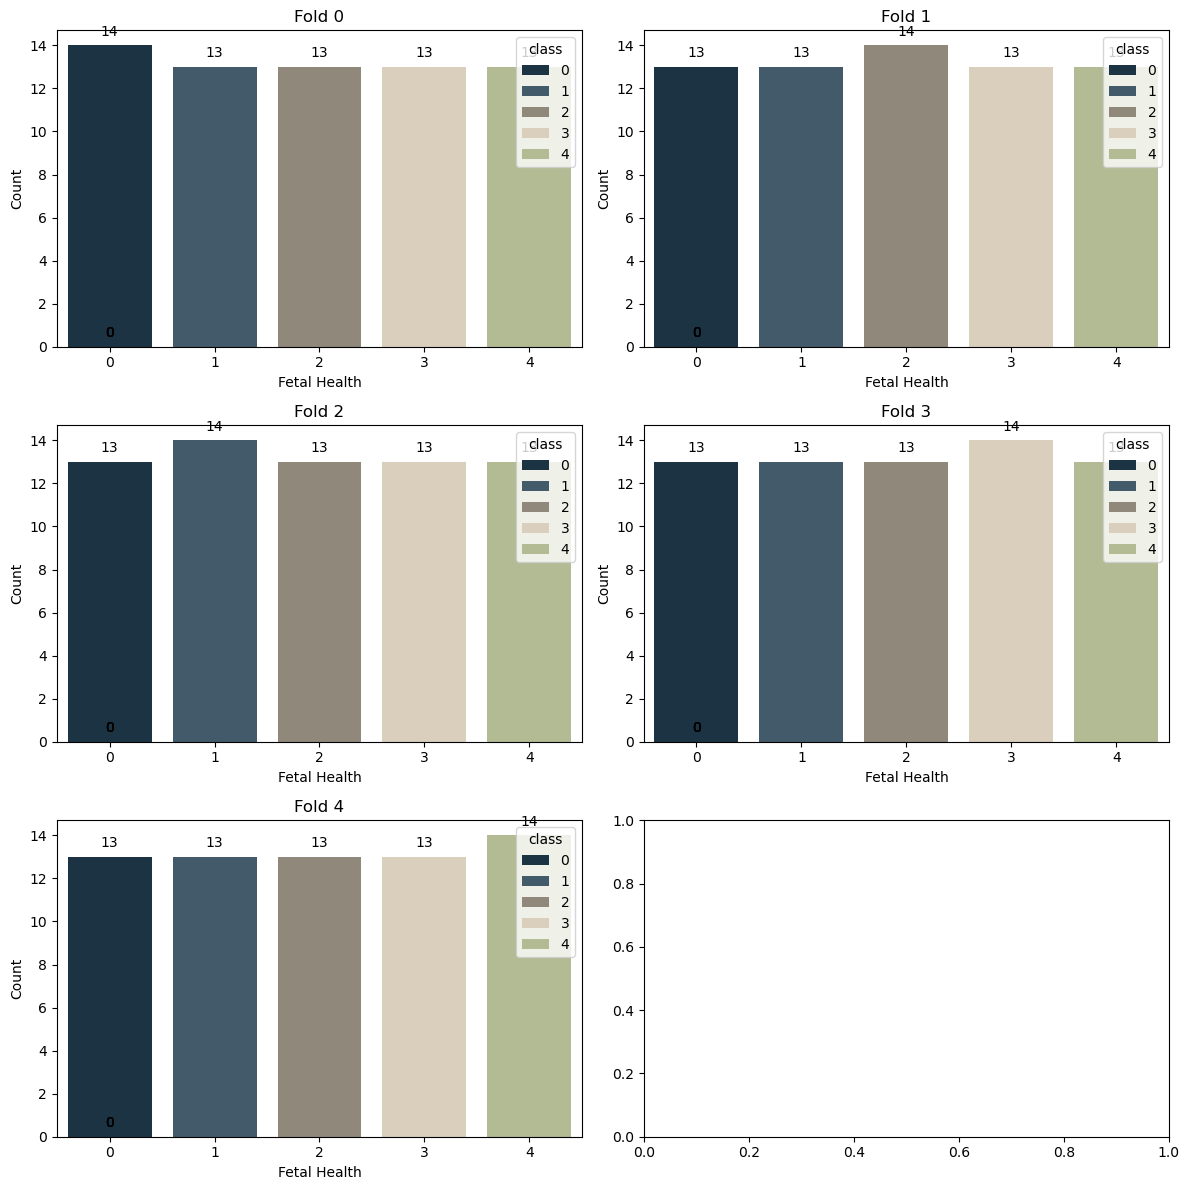

In [72]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
colors = ["#153448", "#3C5B6F","#948979", "#DFD0B8", "#B5C18E"]
for i, ax in enumerate(axes.flat):
    fold_data = smote_data[smote_data['skfold'] == i]
    if not fold_data.empty:
        sns.barplot(data=fold_data, x='class', y='value_counts', ax=ax, palette=colors, hue='class')
        ax.set_title(f'Fold {i}')
        ax.set_xlabel('Fetal Health')
        ax.set_ylabel('Count')
        for p in ax.patches:
            ax.annotate(format(p.get_height(), '.0f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 10), 
                         textcoords = 'offset points')
        
    else:
        break

plt.tight_layout()
plt.show()

# Lets use Under-Sampling

In [78]:
df_resampled_under.to_csv("../data/clean_data/df_undersampling.csv", index=False)

In [79]:
undersample_df = pd.read_csv("../data/clean_data/train_fold_undersample.csv")
undersample_data  = undersample_df.groupby('skfold')['class'].agg({'value_counts'}).reset_index()   
undersample_data

,skfold,class,value_counts
0,0,0,14
1,0,1,13
2,0,2,13
3,0,3,13
4,0,4,13
5,1,2,14
6,1,0,13
7,1,1,13
8,1,3,13
9,1,4,13


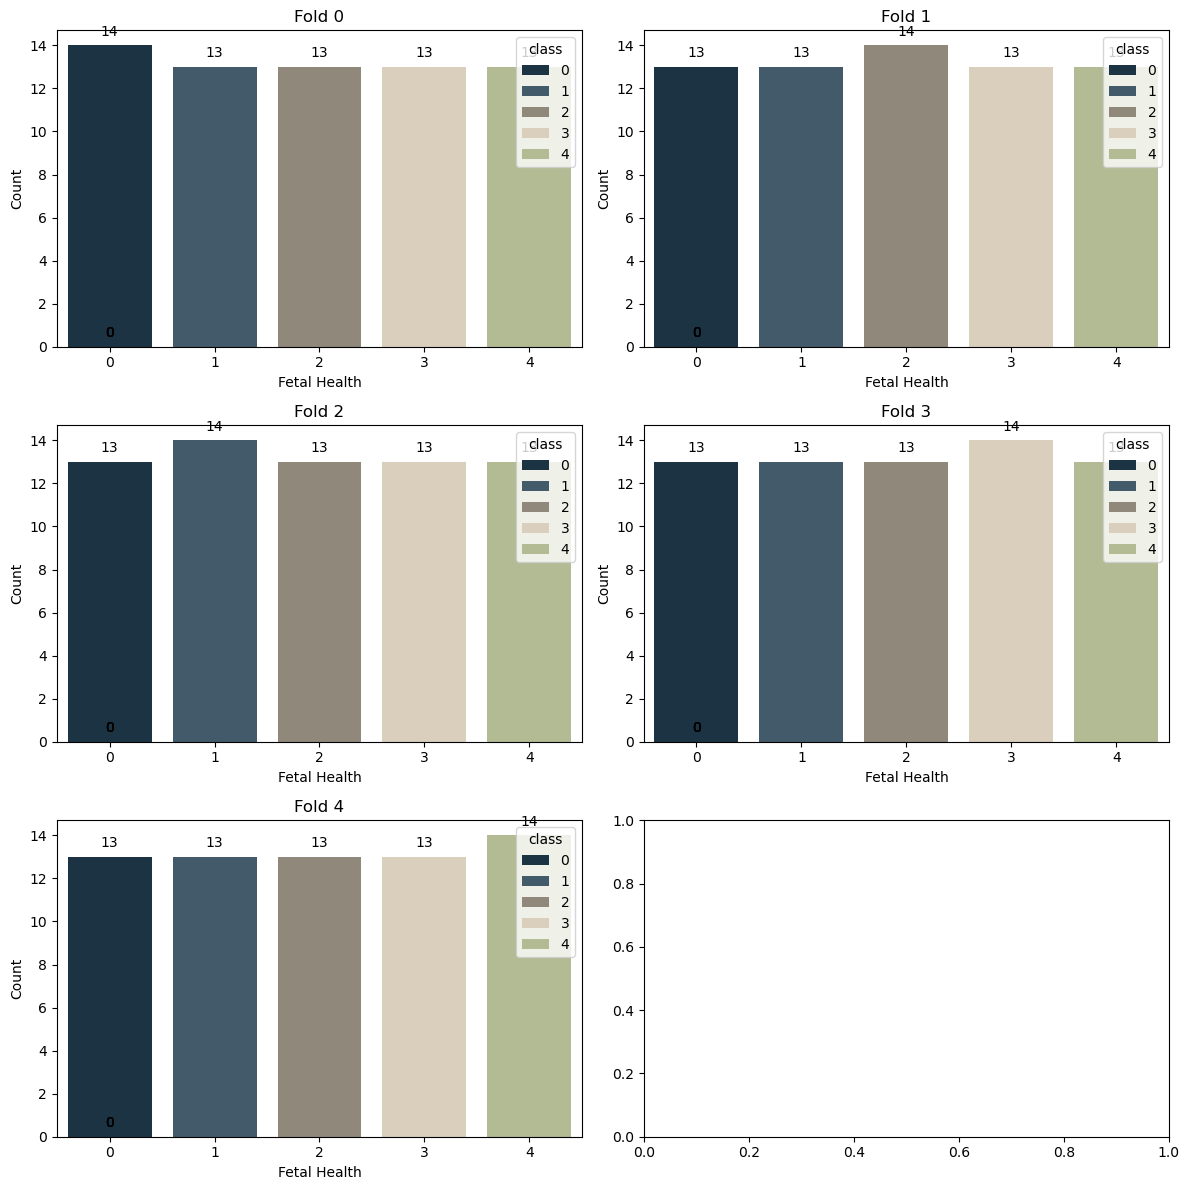

In [91]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
colors = ["#153448", "#3C5B6F","#948979", "#DFD0B8", "#B5C18E"]
for i, ax in enumerate(axes.flat):
    fold_data = undersample_data[undersample_data['skfold'] == i]
    if not fold_data.empty:
        sns.barplot(data=fold_data, x='class', y='value_counts', ax=ax, palette=colors, hue='class')
        ax.set_title(f'Fold {i}')
        ax.set_xlabel('Fetal Health')
        ax.set_ylabel('Count')
        for p in ax.patches:
            ax.annotate(format(p.get_height(), '.0f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 10), 
                         textcoords = 'offset points')
        
    else:
        break

plt.tight_layout()
plt.show()

### <center><b><u><span style="color:#ff6600">OBSERVATIONS✍️</span></u></b></center>

The class distribution after applying `SMOTE oversampling technique`. It seems that the class distribution is now balanced in each fold, with both classes (0 and 1) having approximately the same number of instances.



In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import mlxtend as ml
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs 
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.math import num_combinations
from mlxtend.regressor import StackingRegressor

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, StandardScaler, MinMaxScaler, RobustScaler,Normalizer
import pandas as pd
df_resampled = pd.read_csv('../data/clean_data/df_smote.csv')
X_new = df_resampled.drop('class', axis=1)
y_new = df_resampled['class']
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=.20, random_state=42)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
lr = LogisticRegression()

In [44]:

sfs1 = SFS(
  lr,
  k_features=13,
  forward=True,
  floating=True,
  verbose=2,
  scoring='accuracy',
  cv=5,
  n_jobs=-1
)

sfs1 = sfs1.fit(X_train_scaled, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.0s finished

[2024-06-09 19:20:38] Features: 1/13 -- score: 0.39775036284470244[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished

[2024-06-09 19:20:38] Features: 2/13 -- score: 0.49600870827285914[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=

In [45]:
sfs1.subsets_

{1: {'feature_idx': (4,),
  'cv_scores': array([0.41509434, 0.41509434, 0.32075472, 0.43396226, 0.40384615]),
  'avg_score': 0.39775036284470244,
  'feature_names': ('4',)},
 2: {'feature_idx': (2, 4),
  'cv_scores': array([0.58490566, 0.45283019, 0.45283019, 0.54716981, 0.44230769]),
  'avg_score': 0.49600870827285914,
  'feature_names': ('2', '4')},
 3: {'feature_idx': (2, 4, 12),
  'cv_scores': array([0.60377358, 0.52830189, 0.52830189, 0.54716981, 0.5       ]),
  'avg_score': 0.5415094339622641,
  'feature_names': ('2', '4', '12')},
 4: {'feature_idx': (0, 2, 4, 12),
  'cv_scores': array([0.67924528, 0.54716981, 0.54716981, 0.60377358, 0.51923077]),
  'avg_score': 0.5793178519593614,
  'feature_names': ('0', '2', '4', '12')},
 5: {'feature_idx': (0, 2, 4, 10, 12),
  'cv_scores': array([0.67924528, 0.54716981, 0.56603774, 0.67924528, 0.53846154]),
  'avg_score': 0.6020319303338171,
  'feature_names': ('0', '2', '4', '10', '12')},
 6: {'feature_idx': (0, 2, 4, 5, 10, 12),
  'cv_score

In [46]:
metric_dict = sfs1.get_metric_dict(confidence_interval=0.95)
metric_df = pd.DataFrame.from_dict(metric_dict).T
metric_df

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(4,)","[0.41509433962264153, 0.41509433962264153, 0.3...",0.39775,"(4,)",0.051019,0.039695,0.019847
2,"(2, 4)","[0.5849056603773585, 0.4528301886792453, 0.452...",0.496009,"(2, 4)",0.075237,0.058537,0.029268
3,"(2, 4, 12)","[0.6037735849056604, 0.5283018867924528, 0.528...",0.541509,"(2, 4, 12)",0.044452,0.034585,0.017293
4,"(0, 2, 4, 12)","[0.6792452830188679, 0.5471698113207547, 0.547...",0.579318,"(0, 2, 4, 12)",0.073298,0.057028,0.028514
5,"(0, 2, 4, 10, 12)","[0.6792452830188679, 0.5471698113207547, 0.566...",0.602032,"(0, 2, 4, 10, 12)",0.081837,0.063672,0.031836
6,"(0, 2, 4, 5, 10, 12)","[0.5660377358490566, 0.6226415094339622, 0.528...",0.609869,"(0, 2, 4, 5, 10, 12)",0.081777,0.063625,0.031813
7,"(0, 2, 3, 4, 5, 10, 12)","[0.5849056603773585, 0.6226415094339622, 0.509...",0.617562,"(0, 2, 3, 4, 5, 10, 12)",0.089019,0.06926,0.03463
8,"(0, 2, 3, 4, 5, 10, 11, 12)","[0.660377358490566, 0.660377358490566, 0.62264...",0.640058,"(0, 2, 3, 4, 5, 10, 11, 12)",0.023977,0.018655,0.009327
9,"(0, 2, 3, 4, 5, 7, 10, 11, 12)","[0.660377358490566, 0.660377358490566, 0.62264...",0.640058,"(0, 2, 3, 4, 5, 7, 10, 11, 12)",0.023977,0.018655,0.009327
10,"(0, 2, 3, 4, 5, 7, 8, 10, 11, 12)","[0.660377358490566, 0.660377358490566, 0.62264...",0.640058,"(0, 2, 3, 4, 5, 7, 8, 10, 11, 12)",0.023977,0.018655,0.009327


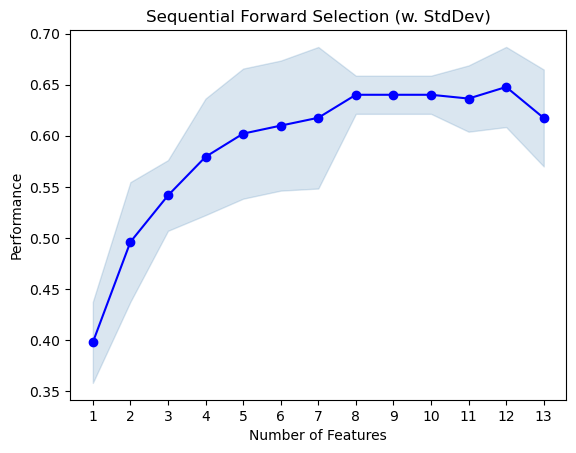

In [47]:
import matplotlib.pyplot as plt
fig1 = plot_sfs(metric_dict, kind='std_dev')
plt.title("Sequential Forward Selection (w. StdDev)")
plt.grid(False)